In [ ]:
# Import libraries and modules
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
pd.options.display.max_columns, pd.options.display.max_rows = 100, 100
import matplotlib.pyplot as plt

# Import classes and functions
from classes import StochasticDsaModel as DSA
from classes import GroupDsaModel as GroupDSA
from functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

<div align="center">

# DSA Demo

Lennard Welslau\
Danmarks Nationalbank and University of Copenhagen\
lennard.welslau@gmail.com\
lennardwelslau.github.io\
February 2025

</div>

# TOC
1. **Background**
2. **Programming approach**
3. **Structure and Functionality**


## Background

- As part of the reform of the Stability and Growth Pact (SGP), the European Commission (EC) proposed using its DSA to define fiscal adjustment targets.
- The EC DSA builds largerly the Debt Sustainability Monitor (DSM) and consists of deterministic and stochastic components (historical variance-covariance matrix approach, Berti 2013).
- During the reform negotiations, quantitative implications were unclear and no open-source version of the DSA was available.
- We replicated the DSA in Python and published several papers using the methodology.

## Publications using DSA

- [*A Quantitative Evaluation of the European Commission’s Fiscal Governance Proposal* (2023) with Darvas, Z. & Zettelmeyer, J. – Bruegel Working Paper](https://www.bruegel.org/sites/default/files/2023-09/WP%2016_1.pdf)
- [*The Implications of the European Union’s New Fiscal Rules* (2024) with Darvas, Z. & Zettelmeyer, J. – Bruegel Working Paper](https://www.bruegel.org/system/files/2024-07/PB%2010%202024.pdf)
- [*Incorporating the Impact of Social Investments and Reforms in the EU's New Fiscal Framework* (2024) with Darvas, Z. & Zettelmeyer, J. – Bruegel Working Paper](https://www.bruegel.org/sites/default/files/2024-03/WP%2007.pdf)
- [*Debt Sustainability Analysis in Reformed EU Fiscal Rules: The Effect of Fiscal Consolidation on Growth and Public Debt Ratios* (2024) with Heimberger, P., Schütz, B., Gechert, S., Guarascio, D. & Zezza, F. – Intereconomics](https://www.intereconomics.eu/contents/year/2024/number/5/article/debt-sustainability-analysis-in-reformed-eu-fiscal-rules.html)
- [*How Demographic Change Will Hit Debt Sustainability in European Union Countries* (2024) with Darvas, Z. & Zettelmeyer, J. – Bruegel Working Paper](https://www.bruegel.org/sites/default/files/2024-09/PB%2022%202024_0.pdf)
- *A Sensitivity Analysis of the European Commission’s Debt Sustainability Model* (Forthcoming) with Darvas, Z. & Zettelmeyer, J.
- *EU Debt and Fiscal Integration* (Forthcoming) with Darvas, Z. & Zettelmeyer, J. - Journal of Economic Perspectives

## Approach

- **Object-Oriented Programming** for modularity and flexibility
- **Country specific DSA Objects** store and manage all input data. Fast and independent handling of mutliple countries.
- **Projection of Economic Variables** via internal functions based on input data and specified policy path/target.
- **Optimization** of policy paths to meet with deterministic and stochastic criteria
- **Dynamic Updates** to input data, model assumptions, or criteria to assess the impacts of policy changes and forecasts.

## Structure

- `DsaModel` core class for simulating deterministic debt paths:
  - Initialization & Data Handling
  - Economic Projections
  - Optimization & Updates

- `StochasticDsaModel` subclass 
  - Stochastic projections and optimization
  - Fanchart visualization

- Modularity allows quick implementation of other features
  - Probability of excessive deficits
  - Long horizon forecasts
  - Policy counterfactuals


### Model Initialization

- Specification of model parameters
- Initializes model variables in memory
- Internal function `_load_input_data` and `_clean_data`
  - Imports CSV data
  - Cleans & assigns data to NumPy arrays  
  - Interpolates long-term values (e.g., inflation, market rates)

In [194]:
model = DSA(
    country='ESP', # ISO code of country
    start_year=2023, # start year of projection, first year is baseline value
    end_year=2070, # end year of projection
    adjustment_period=4, # number of years for linear spb_bca adjustment
    adjustment_start_year=2025, # start year of linear spb_bca adjustment
    ageing_cost_period=10, # number of years for ageing cost adjustment
    fiscal_multiplier_type='pers', # type of fiscal multiplier, 'ec' (commission) or alternative 'pers' (persistent) version 
    bond_data=True, # use bond level data for repayment profile
    )

### `project` method

- Projects GDP accounting for multiplier effects.
- `_project_debt_ratio` and `_calc_debt_ratio` contain core DSA equations
- Scenario specification introduces deterministic shocks

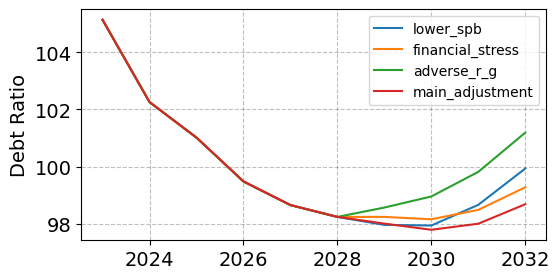

In [198]:
spb_steps = np.array([0.2]*4) # SPB adjustment by 2pp per year 
scenarios = ['lower_spb', 'financial_stress', 'adverse_r_g', 'main_adjustment']
plt.figure(figsize=(6,3))
for s in scenarios:
    model.project(
        spb_steps=spb_steps, # pass policy variable
        scenario=s # specify deterministic scenario
        )
    plt.plot(range(2023,2033), model.d[:10], label=s)
plt.ylabel('Debt Ratio')
plt.legend(fontsize=10)    

### Fast access to model data

- `df` method to leverage pandas or direct access to attributes as numpy arrays

In [185]:
model.df('d', 'spb', 'ageing_cost', 'rg', 'iir').iloc[:10]

,,d,spb,ageing_cost,rg,iir
t,y,,,,,
0,2023,105.142,-1.486,24.315,2.676,2.374
1,2024,102.260,-1.061,24.390,2.967,2.529
2,2025,101.015,-0.861,24.443,2.534,2.603
3,2026,99.479,-0.661,24.527,1.896,2.699
4,2027,98.651,-0.461,24.641,1.424,2.795
5,2028,98.236,-0.261,24.737,1.211,2.893
6,2029,98.002,-0.391,24.876,1.414,2.991
7,2030,97.786,-0.561,25.058,1.649,3.094
8,2031,97.998,-0.775,25.287,1.536,3.200


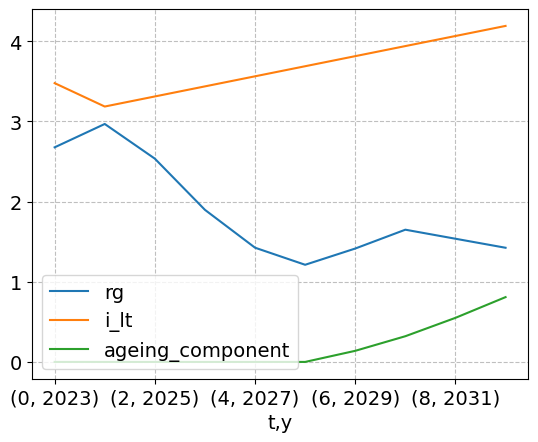

In [186]:
model.df('rg','i_lt', 'ageing_component').iloc[:10] \
    .plot().legend(loc='lower left')

<Axes: title={'center': 'Bond Repayment Profile'}>

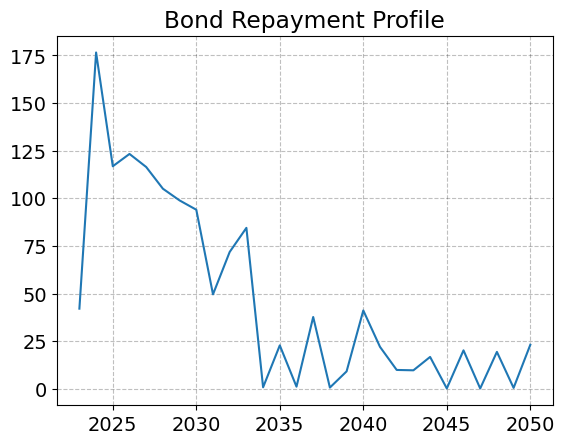

In [187]:
model.df_deterministic_data.BOND_REPAYMENT \
    .loc[:2050] \
    .plot(title='Bond Repayment Profile', xlabel='')

## Deterministic Optimization

- `find_spb_deterministic` identifies SPB path to ensure debt and deficit decline under different scenarios

In [188]:
for s in scenarios:
    t = model.find_spb_deterministic(criterion=s) 
    print(f'{s}: {t:.2f}')

lower_spb: 2.59
financial_stress: 2.14
adverse_r_g: 2.72
main_adjustment: 2.10


## Stochastic Model Subclass

- Extends `DsaModel` for stochastic simulations.
- Integrates deterministic and stochastic optimization.
- Flexible stochastic sample, period, and estimation method
  - `shock_sample_start`, `stochastic_start_year`, `stochastic_period`  
  - `shock_frequency` & `estimation` (covariance, VAR, or bootstrap)
- Fast (functions translated to machine code at runtime using Numba)

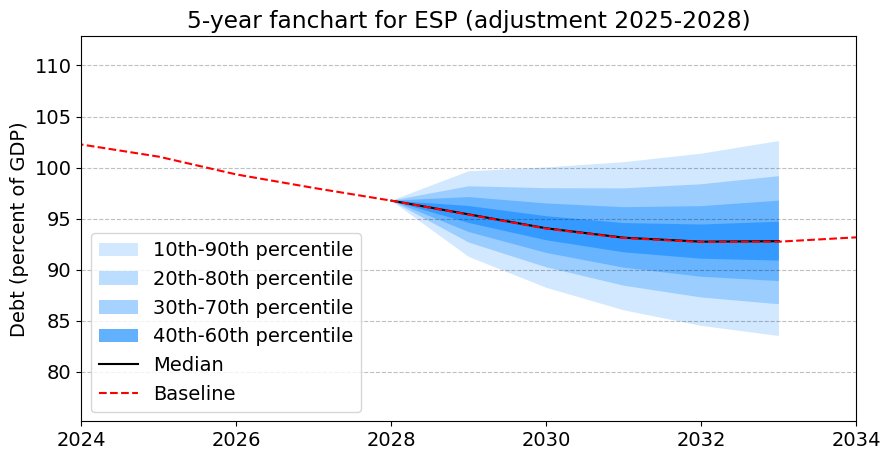

In [190]:
model.find_spb_stochastic(
    bounds=(-20, 20), # bounds for optimization
    stochastic_criteria=['debt_explodes', 'debt_above_60'], # criteria for stochastic optimization
    print_update=True,
    prob_target=None # defaults to 0.3
)
model.fanchart(xlim=(2024, 2034), figsize=(10,5))

### `find_spb_binding` for one-click integrated optimization

In [191]:
model.find_spb_binding()

                  Model Params                             SPB Targets       
================================================     ========================
country                                      ESP     main_adjustment    2.099
adjustment period                              4     lower_spb          2.593
adjustment start                            2025     financial_stress   2.140
shock frequency                        quarterly     adverse_r_g        2.722
stochastic period                      2029-2034     deficit_reduction  2.002
estimation                                normal     stochastic         0.799
bond level data                             True     binding            2.722
safeguards         EDP, debt, deficit_resilience                             
================================================     ========================

                                Binding Params                               
spb_steps                                          0.946, 0.946

### Easy to build additional functionalities

- `GroupDsaModel` Class to initialize and optimizes multiple countries using parallel processing
- `find_deficit_prob` leverages stochastic simulations to calculate the proability of excessive deficits 
- `run_consecutive_dsa` optimizes multiple adjustment periods based on current forecasts
- `fiscal_multiplier_spillover` incorporates foreign demand shocks

In [179]:
model = DSA(
    country='ESP', # ISO code of country
    start_year=2023, # start year of projection, first year is baseline value
    end_year=2070, # end year of projection
    adjustment_period=7, # number of years for linear spb_bca adjustment
    adjustment_start_year=2025, # start year of linear spb_bca adjustment
    ageing_cost_period=10, # number of years for ageing cost adjustment
    shock_sample_start=2000, # start year of shock sample
    stochastic_start_year=None, # start year of stochastic projection, None defaults to adjustment end year
    stochastic_period=5, # number of years for stochastic projection
    shock_frequency='quarterly', # shock frequency of used for estimation
    estimation='normal', # estimation method for covariance matrix, can be normal, var_cholesky, or var_bootstrap
    fiscal_multiplier=0.75, # fiscal multiplier 
    fiscal_multiplier_persistence=3, # persistence of fiscal multiplier in years
    fiscal_multiplier_type='ec', # type of fiscal multiplier, 'ec' (commission) or alternative 'pers' (persistent) version 
    bond_data=False, # use bond level data for repayment profile
    )
model.find_spb_binding(
    edp=False, # apply EDP
    debt_safeguard=False, # apply debt safeguard 
    deficit_resilience=False, # apply deficit resilience safeguard
    stochastic=True, # apply stochastic criterion
    print_results=False, # print results table
    stochastic_criteria=['debt_explodes', 'debt_above_60'], # criteria for stochastic optimization
    save_df=False # save results dataframe to dictionary 'df_dict'
    )

Text(0.5, 1.0, 'P(d>3), 7-year adjustment')

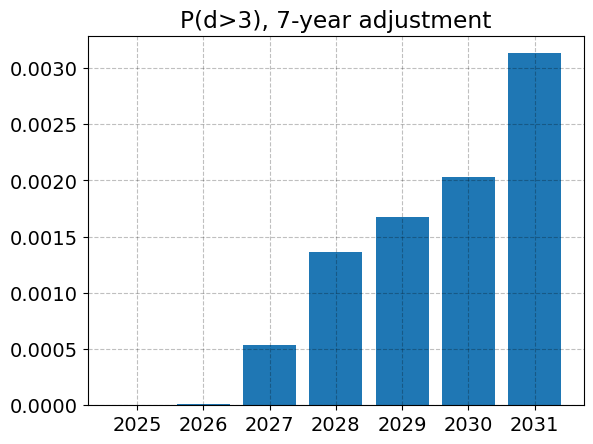

In [181]:
pdef = model.find_deficit_prob()
plt.bar(np.arange(2025, 2032), pdef)
plt.title('P(d>3), 7-year adjustment')

{'main_adjustment': 2.1513999999998115, 'lower_spb': 2.647699999999814, 'financial_stress': 2.188199999999825, 'adverse_r_g': 2.7926999999998, 'deficit_reduction': 2.056099999999823, 'stochastic': 0.7837009216510558, 'binding': 2.7926999999998}
{'main_adjustment': 2.18579999999982, 'lower_spb': 2.6785999999998156, 'financial_stress': 2.208799999999825, 'adverse_r_g': 2.751299999999797, 'deficit_reduction': 1.8612999999998339, 'stochastic': 1.480950590234884, 'binding': 2.751299999999797}
{'main_adjustment': 2.238999999999826, 'lower_spb': 2.5704999999997993, 'financial_stress': 2.258399999999823, 'adverse_r_g': 2.6296999999998176, 'deficit_reduction': 1.5428999999998334, 'stochastic': 1.2997129168820871, 'binding': 2.6296999999998176}


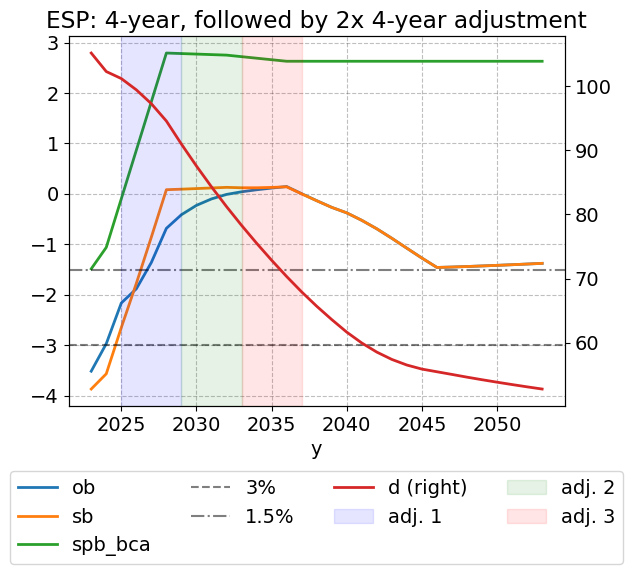

In [192]:
run_consecutive_dsa(country='ESP', print_results=False, plot_results=True)